# Testing the number of events that best explains the data

We usually do not have precise enough information to decide a priori on a number of events that an HSM model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper that we already prepared in section 1 of tutorial 1 and saved in ```sample_data/```. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data).


In [4]:
import os
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from mne.io import read_info

cpus=10#set the number of cores to use for all the code

epoch_data = xr.load_dataset(os.path.join('../sample_data/sample_data.nc'))
#We create also the position array for the electrodes as we are going to need them to plot the event topologies
info = read_info(os.path.join('../sample_data/eeg/processed_0022_epo.fif'), verbose=False)


## Data preparation

First let's transform the data in principal component (PC) space, currently we have the epoched EEG data.

In [5]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 197, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 190 191 192 193 194 195 196
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... nan 2.0 1.0
    resp         (participant, epochs) object 'resp_left' ... 'resp_left'
    rt           (participant, epochs) float64 0.942 1.003 1.129 ... 0.392 0.376
    cue          (participant, epochs) object 'SP' 'AC' 'AC' ... '' 'SP' 'SP'
    movement     (participant, epochs) object 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) object 'SP/stim_right/resp_left' ... '...
  * participant  (participant) object 'processed_0025_epo' ... 'processed_002...
Data variables:
    data         (participant, epochs, channels, samples) float64 2.891 ... nan
Attributes:
    sfreq:    100.0
    offset:   0

When transforming the data, a prompt request us how many PC we want to keep. The best is to maximise the number of components kept so that we don't loose PCs with useful information. However, the more PCs we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PCs that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method).

The HMP `transform_data` function will show you the two graphs below, and ask you how many PCs you would like to retain:

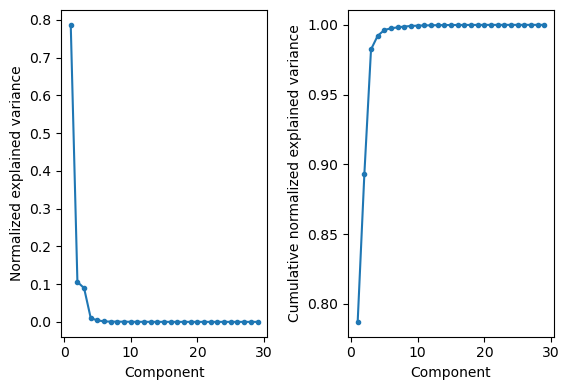

: 

: 

In [6]:
hmp_data = hmp.utils.transform_data(epoch_data, zcore='trial')

In this case we see that 99% is achieved with 4 PCs and this is globally coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with a lot more PC but the elbow might happen before that).

In [ ]:
print(hmp_data)

And we initialize the model

In [ ]:
init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=3)

# Discovering a event number through a cumulative approach

As introduced in Tutorial 2, the ```fit``` function works with starting points to the stage duration from 0 to mean RT. When an event is found (convergences of the expectation maximization algorithm) one event is added to the model and the slide continues. This way we can detect events while accounting for the previous ones. 

In [ ]:
estimates = init.fit()

In [ ]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, times_to_display=np.mean(init.ends - init.starts))

### Illustration of the principle of bootstrapping

In the case of EEG data for a group or even a single participant we can bootstrap the epochs or trials of the EEG. The idea is that 1) generating a bootstraped dataset, 2) fitting a model using the cumulative approach and 3) recording the parameters of the HMP model. We expect that with enough bootstrapped sampels we will know wich events tend to be rare (e.g. strategies) and what is the variance in time and electrode contribution.

In [ ]:
bootstrapped = hmp.resample.bootstrapping(data=epoch_data, dim=[ 'epochs','participant'], n_iterations=1, 
                                                 init=init, positions=info, sfreq=epoch_data.sfreq, cpus=cpus)

Next we compare to the times that we estimated on the initial run:

In [ ]:
times_general_run = init.compute_times(init, estimates, duration=False, mean=True, add_rt=True)
hmp.visu.plot_topo_timecourse(bootstrapped.sel(iteration=0).channels_activity.values, 
                              bootstrapped.sel(iteration=0).event_times.values,
                              info, init, times_to_display=times_general_run.values)

Of course this is automated in the HMP package, here an example for 10 bootstrap samples.

In [ ]:
bootstrapped = hmp.resample.bootstrapping(data=epoch_data, dim=['epochs','participant'], n_iterations=10, 
                                                 init=init, positions=info, sfreq=epoch_data.sfreq, cpus=cpus)

We can then plot the bootstrapped models (or leave the plots argument as True when calling the previous function).

In [ ]:
hmp.visu.plot_topo_timecourse(bootstrapped.channels_activity.values, 
                              bootstrapped.event_times.values,
                              info, init, times_to_display=times_general_run.values)

We can then use these bootstrapped data to 1) assess variability in event detection for a given threshold and 2) the variation in the location of the events and electrode contribution for a given _n_ event model

In [ ]:
hmp.visu.plot_bootstrap_results(bootstrapped, info, init,
                               epoch_data = epoch_data)

The bootstrapped object contains all the bootstrapped run and we can use it to inspect different properties of the bootstrapped sample, e.g. the standard deviation of the scale parameter of the gamma from the last stage:

In [ ]:
bootstrapped.sel(stage=3, parameter="scale").event_times.mean()

## Fitting from the maximum number of events to a 1 event model

An alternative way of assessing the number of events is to use the ```backward_estimation``` as discussed in the previous tutorial. In contrast to the previous tutorial, here we first calculate a fit for a model with the maximum number of fitting events using 100 random starting points, and then use that as starting estimates for the backward estimation.

In [ ]:
max_fit = init.fit_single(init.compute_max_events())
hmp.visu.plot_topo_timecourse(epoch_data, max_fit, info, init)

In [ ]:
%%time 
bests = init.backward_estimation(max_fit=max_fit)#we can also leave the max_fit argument empty and it will be computed as above

Here we plot the resulting solutions going from the maximal possible number of events that fit into the minimum RT given a duration of 50ms (default) in this example .

In [ ]:
hmp.visu.plot_topo_timecourse(epoch_data, bests, info, init, ydim='n_events')

But adding more and more parameters will almost always improve the fit (except when events start pushing each other because of the defined minimum duration). To illustrate this we can plot the raw likelihood

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(bests.n_events, bests.likelihoods,'o-')

plt.ylabel('Log-likelihood')
plt.xlabel('N-event model')
plt.show()

Hence we need a way to penalize the likelihood if the events location do not generalize to all participants. One way to do this is to perform a leave-one out cross-validation. This approach consists in fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters without the participant. The function ```hmp.utils.loocv_mp``` does this and we can apply it to all participants and all *n* event model.

Note that the LOOCV can be very slow when there are a lot of participants, in this case it might be worth it to add multiprocessing through the cpus parameter

In [ ]:
%%time
loocv = hmp.utils.loocv_mp(init, hmp_data, bests, cpus=4)#We set the cpus to 4 as there are 4 participants in the dataset

We can then plot the result from the LOOCV procedure, with the likelihood per participant in the graph on the left, and the changes in likelihood on the right.

In [ ]:
hmp.visu.plot_loocv(loocv, pvals=True, test='sign', indiv=True)#Colored shaded lines represent individuals

With 4 participants the results are obviously not to be taken too seriously. The figure contains the p-value for a sign test evaluating whether the fit improved for a significant number of subjects, but it cannot be significant with 4 participants. In this case going 4 events is the best option (see right panel), considering that it has the most events for which a significant number of participants improved (4/4).

In [ ]:
selected = bests.sel(n_events=4)

hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init,  figsize=(12,1),
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

This selection method suggests one more event although the evidence is not large. With enough participants all event selection models should eventually converge.

# Using clustering on the sliding event function

As seen in the previous tutorial we can also use several starting points on both the parameters and the magnitudes using the sliding event function.

In [ ]:
#calc estimates
lkhs, mags, channels, times = init.sliding_event_mags(epoch_data, step=3, decimate_grid = 3, cpu=cpus, plot=True, min_iteration=10)

# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(init, lkhs, mags, channels, times, method='time_x_lkh_x_mags', max_clust=10, p_outlier=.05, info=info, calc_outliers=True)

#fit final model
best_estimate = init.fit_single(mags_cl.shape[0], magnitudes=mags_cl,parameters=pars_cl)
hmp.visu.plot_topo_timecourse(epoch_data, best_estimate, info, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', contours=0, event_lines=True, colorbar=True)

This method is in agreement with the ```fit()``` method of the first section.

After these selection procedure we can move to further analysis of the data and the HMP partition, see next tutorial.